#### Import libraries

In [89]:
import torch
from matplotlib import pyplot as plt
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import string
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.linear_model import LogisticRegression
from typing import List, Dict

#### Data loading and exploratory analysis

In [90]:
df = pd.read_csv("../../datasets/movie/IMDB Dataset.csv")

In [91]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [92]:
print(f"Shape: {df.shape}")
print(f"Columns: {df.columns}")

Shape: (50000, 2)
Columns: Index(['review', 'sentiment'], dtype='object')


Checking for null values

In [93]:
print(f"Null values:\n{df.isnull().sum()}")

Null values:
review       0
sentiment    0
dtype: int64


In [94]:
print(f"Unique output classes: {df['sentiment'].unique()}")

Unique output classes: ['positive' 'negative']


Checking for imbalance in data

positive    25000
negative    25000
Name: sentiment, dtype: int64


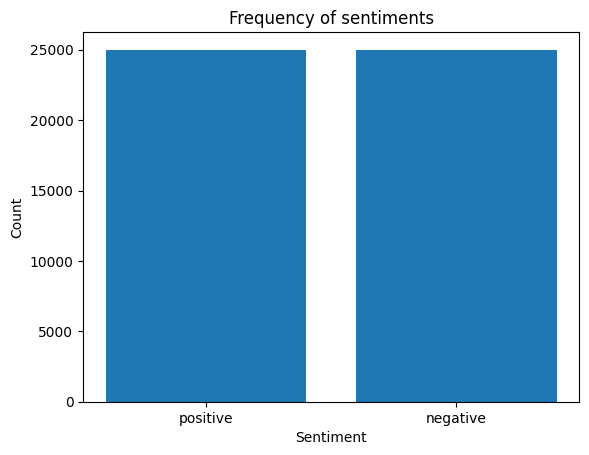

In [95]:
print(df["sentiment"].value_counts())
plt.title("Frequency of sentiments")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.bar(df["sentiment"].value_counts().index, df["sentiment"].value_counts().values)
plt.show()

The dataset is **balanced**

### Split data into train and test sets

In [96]:
train = df.sample(frac=0.8)  # train size is 80% of all data
test = df.drop(train.index)
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

### Preprocessing text data

In [97]:
def preprocess(text: str) -> str:
    """
    Function to preproces text

    Parameters
    ----------
    text: `str`
        Text that is to be preprocessed

    Returns
    -------
    text: `str`
        Preprocessed text
    """

    text = text.lower()
    text = text.replace("<br />", " ")  # Remove <br> tags
    text = text.translate(
        str.maketrans(string.punctuation, " " * len(string.punctuation))
    )  # Remove punctuations
    text = re.sub(r"\d", "", text)  # Remove digits

    words = word_tokenize(text)  # tokenize words
    stemmer = PorterStemmer()
    stopwords_english = stopwords.words("English")
    for word in words:
        if word in stopwords_english:
            text = re.sub(r"\b%s\b" % word, "", text)
        else:
            stemmed_word = stemmer.stem(word)
            text = re.sub(
                r"\b%s\b" % word, stemmed_word, text
            )  # replace each word with its stemmed version

    text = re.sub(" +", " ", text)  # Remove extra spaces
    text = text.strip()

    return text

In [98]:
print(f"Before cleaning: {train['review'][0]}")
train["review"] = train["review"].map(preprocess)
print("----------------------------------------")
print(f"After cleaning: {train['review'][0]}")

Before cleaning: I am not going to lie. Despite looking interesting, I watched The Notorious Bettie Page because I had heard (and it was fairly obvious just by looking at a synopsis or anything about the film), that Gretchen Mol got naked in it. I have never been a fan of Mol, but I cannot resist seeing an attractive woman taking off her clothes. Yes, that may be perverted, but its a theme and ideal central to the very core of the movie, and helps to make the film a lot stronger than it probably should be.<br /><br />The film chronicles Bettie Page's (Mol) life from her physical and sexually abused days as a kid in high school in the South, and onto her new life in New York. She wants to be an actress, but she has to pay bills too. After taking a few seemingly innocent shots on a local beach, Page slowly becomes a modeling sensation, and quickly jumps from suggestive photos to sexually provocative pin-up photographs.<br /><br />I feel the briefness of the film (just over ninety minutes

### Create word vocabulary

In [100]:
def create_vocab(df: pd.DataFrame) -> Dict[str, int]:
    """
    Function used to create a vocabulary of all words with their counts in the given corpus

    Parameters
    ----------
    df: `pd.DataFrame`
        Dataframe object containing the corpus

    Returns
    -------
    vocab: `Dict[str, int]`
        Vocabulary containing all words with their counts
    """

    vocab = {}
    stopwords_english = stopwords.words("English")
    for review in df.values:
        words = word_tokenize(review)
        for word in words:
            if word not in stopwords_english:
                if word not in vocab:
                    vocab[word] = 1
                else:
                    vocab[word] += 1

    return vocab

In [101]:
pos_vocab = create_vocab(train["review"][train["sentiment"] == 1])
neg_vocab = create_vocab(train["review"][train["sentiment"] == 0])

### Vectorizing input data

In [102]:
# def create_review_tensor(review):

#     review_tensor = torch.zeros(3000, 2)
#     words = word_tokenize(review)
#     for idx, word in enumerate(words):
#         if word in pos_vocab:
#             review_tensor[idx][0] = pos_vocab[word]
#         if word in neg_vocab:
#             review_tensor[idx][1] = neg_vocab[word]

#     return review_tensor.reshape(6000, 1)

Using tfidf to vectorize input data

In [104]:
tfidf = TfidfVectorizer(max_features=10000)
tfidf.fit(train["review"])
train_x = tfidf.transform(train["review"])

Converting sparse matrix to tensors

In [105]:
coo_train = train_x.tocoo()
values = coo_train.data
indices = np.vstack((coo_train.row, coo_train.col))
i = torch.LongTensor(indices)
v = torch.FloatTensor(values)
shape = coo_train.shape

train_x = torch.sparse.FloatTensor(i, v, torch.Size(shape)).to_dense()

Representing sentiment as integers - Positive: 1 Negative: 0

In [99]:
train["sentiment"][train["sentiment"] == "positive"] = 1
train["sentiment"][train["sentiment"] == "negative"] = 0
train["sentiment"] = train["sentiment"].astype(int)  # to convert str '1' to int 1

In [106]:
# Reshaping output to fit model
train_y = torch.tensor(train["sentiment"]).reshape(40000, 1)

In [107]:
train_x.shape, train_y.shape

(torch.Size([40000, 10000]), torch.Size([40000, 1]))

### Logistic Regression model

In [151]:
class LogisticBinary:
    """
    Class that represents the Logistic Regression Model

    Attributes
    ----------
    X: ``torch.Tensor``
        Input data to the model
    Y: ``torch.Tensor``
        Output data used for supervised learning
    n_iterations: ``int`` ( default = 10 )
        Number of times the training samples are to be read / No. of iterations of model
    learning_rate: ``str`` ( default = 0.1 )
        Learning rate used to affect the rate of gradient descent
    print_cost: ``str`` ( default = False )
        Flag that determines if cost is to be printed while training the model
    draw_cost: ``str`` ( default = False )
        Flag that determines if a plot of cost function vs epoch is to be drawn
    params: ``str`` ( default = {} )
        Parameters of the model
    grads: ``str`` ( default = {} )
        Gradient of every parameter
    costs: ``str`` ( default = [] )
        List containing cost after each epoch
    """

    def __init__(
        self,
        X: torch.Tensor,
        Y: torch.Tensor,
        n_iterations: int = 100,
        learning_rate: float = 0.1,
        print_cost: bool = False,
        draw_cost: bool = False,
    ):
        self.X = X
        self.Y = Y
        self.n_iterations = n_iterations
        self.learning_rate = learning_rate
        self.print_cost = print_cost
        self.draw_cost = draw_cost
        self.m = X.shape[0]
        # self.max_val = max_val
        self.params = {}
        self.grads = {}
        self.costs = []

    def initialize_params(self) -> Dict[str, torch.Tensor]:
        """
        Initialize parameters for the model

        Returns
        -------
        parameters: ``Dict[str, torch.Tensor]``
        """

        # w = torch.rand((6000, 1)) * 0.001
        w = torch.rand((10000, 1)) * 0.01
        b = torch.zeros((1, 1))

        self.params["w"] = w
        self.params["b"] = b

        return self.params

    def compute_cost(self, a: torch.Tensor) -> torch.Tensor:
        """
        Compute the cost of the model

        Parameters
        ----------
        a: ``torch.Tensor``
            Activation output of the final layer

        Returns
        -------
        cost: ``torch.Tensor``
            Cost of the model after one forward pass
        """

        cost = -torch.mean(
            (
                (self.Y * torch.log(a).transpose(0, 1))
                + ((1 - self.Y) * torch.log(1 - a).transpose(0, 1))
            )
        )

        return cost

    def forward_propagation(self, X: torch.Tensor) -> torch.Tensor:
        """
        Perform one forward pass

        Parameters
        ----------
        X: ``torch.Tensor``
            Tensor containing the input features

        Returns
        -------
        z: ``torch.Tensor``
        """

        w = self.params["w"]
        b = self.params["b"]
        z = torch.mm(w.transpose(0, 1), X.transpose(0, 1)) + b

        return z

    def backpropagation(self, a: torch.Tensor) -> Dict[str, torch.Tensor]:
        """
        Perform one backward pass

        Parameters
        ----------
        a: ``torch.Tensor``
            Tensor containing the activations of the final layer

        Returns
        -------
        gradients: ``Dict[str, torch.Tensor]``
            Gradients required to modify parameters of the model
        """

        dw = torch.mm(self.X.transpose(0, 1), (a.transpose(0, 1) - self.Y)) / 40

        db = torch.mean(a - self.Y.transpose(0, 1))

        self.grads["dw"] = dw
        self.grads["db"] = db
        return self.grads

    def optimize(self) -> Dict[str, torch.Tensor]:
        """
        Optimize the model by updating its parameters

        Returns
        -------
        parameters: ``Dict[str, torch.Tensor``
        """

        w = self.params["w"]
        b = self.params["b"]
        dw = self.grads["dw"]
        db = self.grads["db"]

        w -= self.learning_rate * dw
        b -= self.learning_rate * db

        self.params["w"] = w
        self.params["b"] = b

        return self.params

    def train(self) -> Dict[str, torch.Tensor]:
        """
        Perform training on the model

        Returns
        -------
        parameters: ``Dict[str, torch.Tensor]``
            The final parameters of the model that can be used to make predictions
        """

        self.params = self.initialize_params()

        for i in range(self.n_iterations):
            z = self.forward_propagation(self.X)
            a = torch.sigmoid(z)
            cost = self.compute_cost(a)
            self.costs.append(cost)

            if self.print_cost and (i % 10) == 0:
                print(f"Cost for iteration {i}: {cost}")

            self.grads = self.backpropagation(a)
            self.params = self.optimize()

        if self.draw_cost:
            self.draw()

        return self.params

    def draw(self):
        """
        Method to plot the variation of cost of model over different epochs
        """

        plt.plot(range(0, self.n_iterations), self.costs)
        plt.xlabel("No. of iterations")
        plt.ylabel("Cost Function")
        plt.show()

    def predict(self, X_test: torch.Tensor) -> torch.Tensor:
        """
        Perform predictions for given input data

        Parameters
        ----------
        X_test: ``torch.Tensor``
            Tensor containing the input data for which predictions are to be obtained

        Returns
        -------
        predictions: ``torch.Tensor``
            Tensor that holds the predictions for given input data
        """

        # X_test = preprocess(X_test)
        # X_tensor = create_review_tensor(X_test)
        # X_tensor = X_tensor.reshape(1, 6000) / self.max_val

        # a = torch.zeros((1, X_tensor.shape[0]))

        z = self.forward_propagation(X_test)
        a = torch.sigmoid(z)

        a[a < 0.5] = int(0)
        a[a >= 0.5] = int(1)

        return torch.squeeze(a)

    def score(self, X_test: torch.Tensor, Y_test: torch.Tensor) -> Dict[str, float]:
        """
        Perform one backward pass

        Parameters
        ----------
        X_test: ``torch.Tensor``
            Tensor containing the input data

        Y_test: ``torch.Tensor]``
            Tensor containing output data for corresponding input data

        Returns
        -------
        scores: ``Dict[str, float]``
            Tensor containing output data for corresponding input data
        """

        predictions = self.predict(X_test)
        scores = {}

        TP, TN, FP, FN = (0, 0, 0, 0)
        for y, prediction in zip(Y_test, predictions):
            # True Positive
            if (
                torch.IntTensor.item(y) == 1
                and int(torch.IntTensor.item(prediction)) == 1
            ):
                TP += 1
            # True Negative
            elif y == 0 and prediction == 0:
                TN += 1
            # False positive
            elif y == 0 and prediction == 1:
                FP += 1
            # False negative
            elif y == 1 and prediction == 0:
                FN += 1

        accuracy = (TP + TN) / (TP + TN + FP + FN)
        precision = TP / (TP + FP)
        recall = TP / (TP + FN)
        specificity = TN / (TN + FP)
        f1_score = 2 * ((precision * recall) / (precision + recall))

        scores["accuracy"] = round(accuracy, 2)
        scores["precision"] = round(precision, 2)
        scores["recall"] = round(recall, 2)
        scores["specificity"] = round(specificity, 2)
        scores["f1_score"] = round(f1_score, 2)

        return scores

In [119]:
# def create_input():
#     m = train['review'].shape[0]
#     input = torch.zeros(m, 6000, 1)
#     for i in range(m):
#         input[i] = create_review_tensor(train['review'][i])
#     input = input.reshape((40000, 6000))
#     input = input / torch.max(input)

#     return input, torch.max(input)

In [115]:
# train_x, max_val = create_input()

In [ ]:
train_y = torch.tensor(train["sentiment"]).reshape(40000, 1)
train_x.shape, train_y.shape

In [120]:
train_x.shape, train_y.shape

(torch.Size([40000, 6000]), torch.Size([40000, 1]))

Cost for iteration 0: 0.6932435631752014
Cost for iteration 10: 1.1940609216690063
Cost for iteration 20: 1.1716121435165405
Cost for iteration 30: 1.151837944984436
Cost for iteration 40: 1.1338529586791992
Cost for iteration 50: 1.116973876953125
Cost for iteration 60: 1.1008431911468506
Cost for iteration 70: 1.0852864980697632
Cost for iteration 80: 1.070204496383667
Cost for iteration 90: 1.0555341243743896


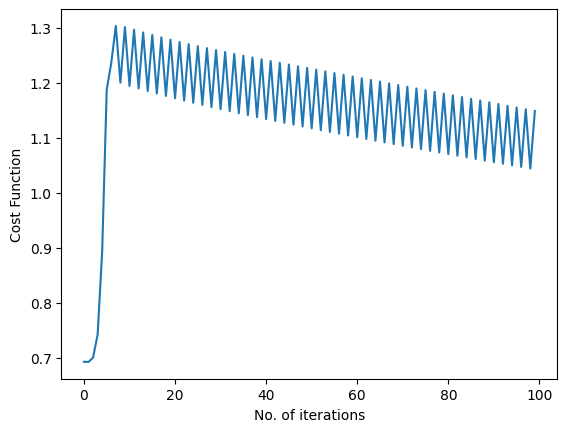

In [152]:
cls = LogisticBinary(
    train_x,
    train_y,
    n_iterations=100,
    learning_rate=0.01,
    print_cost=True,
    draw_cost=True,
)
params = cls.train()

In [108]:
test["review"] = test["review"].map(preprocess)
test_x = tfidf.transform(test["review"])
coo_test = test_x.tocoo()
values = coo_test.data
indices = np.vstack((coo_test.row, coo_test.col))
i = torch.LongTensor(indices)
v = torch.FloatTensor(values)
shape = coo_test.shape

test_x = torch.sparse.FloatTensor(i, v, torch.Size(shape)).to_dense()

In [ ]:
test["sentiment"][test["sentiment"] == "positive"] = 1
test["sentiment"][test["sentiment"] == "negative"] = 0
test["sentiment"] = test["sentiment"].astype(int)

test_y = torch.tensor(test["sentiment"]).reshape(10000, 1)

/tmp/ipykernel_6902/3057215181.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['sentiment'][test['sentiment'] == "positive"] = 1
/tmp/ipykernel_6902/3057215181.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['sentiment'][test['sentiment'] == "negative"] = 0


In [ ]:
cls.predict(test_x)

tensor([1., 0., 0.,  ..., 0., 1., 1.])

In [ ]:
cls.score(test_x, test_y)

4394 4082 900 624


{'accuracy': 0.85,
 'precision': 0.83,
 'recall': 0.88,
 'specificity': 0.82,
 'f1_score': 0.85}